In [1]:
import os
import opyplus as op
import matplotlib.pyplot as plt
import pandas as pd
data_path = "../../data/sinergym/"
epw_files = os.listdir(data_path)
weather_dfs = []
base_df = None
for file in epw_files:
    # load weather data object
    try:
        if "USA" in file:
            weather_data = op.WeatherData.from_epw(os.path.join(data_path, file))
            weather_dfs.append(weather_data.get_weather_series())
            if file == 'USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw':#'USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw':
            #if file == "USA_AZ_Tucson-Davis-Monthan.AFB.722745_TMYx.2007-2021.epw":
                base_df = weather_dfs[-1]
    except Exception as e:
        print(e)

In [2]:
big_df = pd.concat(weather_dfs)
variables = ['drybulb', 'relhum', "winddir", "dirnorrad", "difhorrad", "windspd", "precip_wtr", "snowdepth"]

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

def calculate_deviations(base_df, variable, n):
    base_df_cpy = base_df[variable]
    moving_avg = base_df_cpy.rolling(n).mean()
    return base_df_cpy.iloc[n:] - moving_avg.iloc[n:]

def split_data(deviations):
    num_train = int(0.8 * len(deviations))
    train_X = np.array(deviations.iloc[:num_train]).reshape([-1, 1])
    train_Y = np.array(deviations.iloc[1:num_train + 1]).reshape([-1, 1])
    eval_X = np.array(deviations.iloc[num_train:-1]).reshape([-1, 1])
    eval_Y = np.array(deviations.iloc[num_train+1:]).reshape([-1, 1])
    return train_X, train_Y, eval_X, eval_Y

def normalize_data(train_X, train_Y, eval_X, eval_Y):
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()
    train_X = scaler_X.fit_transform(train_X)
    train_Y = scaler_Y.fit_transform(train_Y)
    eval_X = scaler_X.transform(eval_X)
    eval_Y = scaler_Y.transform(eval_Y)
    return train_X, train_Y, eval_X, eval_Y, scaler_X, scaler_Y

def train_and_evaluate(train_X, train_Y, eval_X, eval_Y):
    reg = LinearRegression()
    reg.fit(train_X, train_Y)
    score = reg.score(eval_X, eval_Y)
    return reg, score

def calculate_parameters(reg, deviations, scaler_x, scaler_y):
    coef = reg.coef_.squeeze().item()
    intercept = reg.intercept_.squeeze().item()
    dt = 1 / len(deviations)
    tau = dt / (1 - coef)
    mu = intercept * tau / dt # intercept = mu * dt / tau
    scaler_y.inverse_transform(np.array([[mu]]))[0][0]
    return mu, tau, dt

def calculate_sigma(reg, train_X, train_Y, tau, scaler_x, scaler_y):
    preds = scaler_y.inverse_transform(reg.predict(train_X))
    targets = scaler_y.inverse_transform(train_Y)
    
    std = np.sqrt(np.mean((preds - targets) ** 2))
    sigma = std / (np.sqrt(dt * 2. / tau))
    return sigma

n = 168
base_OU_params = {}
for variable in variables:
    deviations = calculate_deviations(base_df, variable, n)
    print(deviations)
    
    train_X, train_Y, eval_X, eval_Y = split_data(deviations)
    train_X, train_Y, eval_X, eval_Y, scaler_X, scaler_Y = normalize_data(train_X, train_Y, eval_X, eval_Y)
    reg, score = train_and_evaluate(train_X, train_Y, eval_X, eval_Y)
    print("SCORE IS: ", score)
    
    
    mu, tau, dt = calculate_parameters(reg, deviations, scaler_X, scaler_Y)
    sigma = calculate_sigma(reg, train_X, train_Y, tau, scaler_X, scaler_Y)
    print(mu, sigma, tau)
    base_OU_params[variable] = (sigma, mu, tau)
base_OU_params = pd.DataFrame.from_dict(base_OU_params)


168     3.808929
169     3.729167
170     3.644048
171     2.555952
172     2.461905
          ...   
8755    2.716667
8756    1.692857
8757   -0.319048
8758    0.657143
8759    2.627381
Name: drybulb, Length: 8592, dtype: float64
SCORE IS:  0.9162951966869103
5.354165991418429e-16 5.531731866128253 0.0025503494379979213
168     13.285714
169     13.339286
170      9.452381
171     16.559524
172     16.690476
          ...    
8755   -10.642857
8756    -8.601190
8757    -5.577381
8758    -7.529762
8759   -10.494048
Name: relhum, Length: 8592, dtype: float64
SCORE IS:  0.9394949880247473
7.655758290299035e-16 17.312887196077604 0.0023171275985263765
168     -76.130952
169     -75.357143
170     -64.940476
171      -4.940476
172      -4.523810
           ...    
8755     31.309524
8756    110.416667
8757    -39.642857
8758    -69.583333
8759    -29.702381
Name: winddir, Length: 8592, dtype: float64
SCORE IS:  0.45223292600832365
2.247335012962023e-18 73.99846538345739 0.00040229801291031

In [4]:
base_df[1000:]

,year,month,day,hour,minute,datasource,drybulb,dewpoint,relhum,atmos_pressure,...,ceiling_hgt,presweathobs,presweathcodes,precip_wtr,aerosol_opt_depth,snowdepth,days_last_snow,Albedo,liq_precip_depth,liq_precip_rate
1000,2005,2,11,17,NaN,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,14.0,12.0,88.0,91700.0,...,720.0,NaN,,240.0,0.037,0.0,88.0,0.2,3.0,6.0
1001,2005,2,11,18,NaN,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,14.0,13.0,94.0,91700.0,...,1050.0,NaN,,240.0,0.037,0.0,88.0,0.2,NaN,NaN
1002,2005,2,11,19,NaN,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,14.0,13.0,94.0,91700.0,...,1410.0,NaN,,240.0,0.037,0.0,88.0,0.2,NaN,NaN
1003,2005,2,11,20,NaN,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,14.0,14.0,100.0,91700.0,...,1410.0,NaN,,240.0,0.037,0.0,88.0,0.2,NaN,NaN
1004,2005,2,11,21,NaN,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,14.0,14.0,100.0,91700.0,...,1410.0,NaN,,229.0,0.037,0.0,88.0,0.2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2005,12,31,20,NaN,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,16.0,-5.0,22.0,91800.0,...,7500.0,NaN,,150.0,0.039,0.0,88.0,0.2,NaN,NaN
8756,2005,12,31,21,NaN,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,15.0,-5.0,24.0,91800.0,...,7500.0,NaN,,150.0,0.039,0.0,88.0,0.2,NaN,NaN
8757,2005,12,31,22,NaN,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,13.0,-5.0,27.0,91700.0,...,7500.0,NaN,,150.0,0.039,0.0,88.0,0.2,NaN,NaN
8758,2005,12,31,23,NaN,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,14.0,-5.0,25.0,91700.0,...,7500.0,NaN,,150.0,0.039,0.0,88.0,0.2,NaN,NaN


In [5]:
import numpy as np
diffs = np.array(base_df["drybulb"])[1:] - np.array(base_df["drybulb"])[:-1]

a = pd.Series(diffs)
a.describe()

count    8759.000000
mean        0.001187
std         1.701477
min       -12.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         7.000000
dtype: float64

### Overall Process of Embedding OU Parameters into a low dimensional space:
We model each weather file as having been generated from an OU process adding noise to the "base" weather of our environment. After recovering the OU parameters, we can encode them in a low dimensional space using PCA, which will capture the covariances between the parameters for each individual variable.

1. Subtract each epw from base epw and rescale using base epw's std deviation
2. Since OU process is auto-generative, we use a linear regression to predict the effect x[t] had on x[t+1]
3. Do some math on the linear regression outputs to recover the MLE of the OU process parameters for each variable for each epw
4. Standardize the recovered OU parameters
5. Fit PCA to the parameters

When generating new epw files:
1. Sample a uniform random variable and multiply it by the PCA
2. Rescale the new parameters by subtracting OU means and variances
3. Rescale again by multiplying OU offset and std parameters by the base epw's std deviation


In [6]:
base_df = base_df[variables]
df_mean = base_df.mean(0)
df_std = base_df.std(0)
df_std[df_std == 0] = 1
dt = 1/8760

In [7]:
df_std

drybulb         9.003335
relhum         23.782531
winddir        82.218378
dirnorrad     358.688955
difhorrad      86.422528
windspd         1.811650
precip_wtr     84.068268
snowdepth       1.000000
dtype: float64

In [8]:
store_weather_min = np.full((len(variables),), np.inf)
store_weather_max = np.full((len(variables),), -np.inf)
for i in range(len(weather_dfs)):
    store_weather_min = np.minimum(weather_dfs[i][variables].min(), store_weather_min)
    store_weather_max = np.maximum(weather_dfs[i][variables].max(), store_weather_max)
    weather_dfs[i] = (weather_dfs[i][variables] - base_df) / (df_std + 0.0000001)

In [9]:
big_df = pd.concat(weather_dfs)
big_df.describe()

,drybulb,relhum,winddir,dirnorrad,difhorrad,windspd,precip_wtr,snowdepth
count,1.294728e+07,1.294728e+07,1.294728e+07,1.294728e+07,1.294728e+07,1.294728e+07,1.294728e+07,1.294728e+07
mean,-1.093482e+00,1.360681e+00,-2.219868e-01,-2.825541e-01,9.275677e-02,3.000955e-01,-2.697253e-01,4.333823e-01
std,1.001236e+00,1.203614e+00,1.659077e+00,8.637207e-01,7.952110e-01,1.693164e+00,1.539851e+00,3.715370e+00
min,-8.596814e+00,-3.994529e+00,-4.378583e+00,-2.879933e+00,-6.398794e+00,-7.672564e+00,-5.352793e+00,0.000000e+00
25%,-1.688263e+00,5.886674e-01,-1.459528e+00,-4.683724e-01,0.000000e+00,-8.279746e-01,-1.189509e+00,0.000000e+00
50%,-1.032951e+00,1.471668e+00,-2.432546e-01,0.000000e+00,0.000000e+00,2.759915e-01,-3.568528e-01,0.000000e+00
75%,-4.331728e-01,2.270574e+00,9.730185e-01,0.000000e+00,1.619948e-01,1.324759e+00,5.947547e-01,0.000000e+00
max,3.998518e+00,4.078624e+00,4.378583e+00,3.950498e+00,6.850066e+00,4.117794e+01,7.256008e+00,1.370000e+02


In [10]:
weather_dfs[0].shape

(8760, 8)

In [11]:
from sklearn.linear_model import LinearRegression
import numpy as np
OU_vars = {k: [] for k in weather_dfs[0].columns}
all_OU = []
scores = {k: [] for k in weather_dfs[0].columns}
all_scores = []
coefs = []
intercepts = []
for i in range(len(weather_dfs)):
    if np.any(weather_dfs[i].isna()):
        continue
    for j in range(weather_dfs[i].shape[-1]):
        reg = LinearRegression()
        split = int(8760 * 0.8)
        X_train = np.array(weather_dfs[i].iloc[:split-1, j]).reshape([-1, 1])
        y_train = np.array(weather_dfs[i].iloc[1:split, j]).reshape([-1, 1])
        X_test = np.array(weather_dfs[i].iloc[split:-1, j]).reshape([-1, 1])
        y_test = np.array(weather_dfs[i].iloc[split+1:, j]).reshape([-1, 1])
        reg = reg.fit(X_train, y_train)
        preds = reg.predict(X_train)
        std = np.sqrt(np.mean((preds - y_train) ** 2))
        score = reg.score(X_test, y_test)
        scores[weather_dfs[i].columns[j]].append(score)
        coef = reg.coef_.squeeze().item()
        coefs.append(coef)
        intercept = reg.intercept_.squeeze().item()
        intercepts.append(intercept)
        if coef == 0:
            tau = 0.001
        else:
            tau = dt / (1 - coef)
        mu = intercept * tau / dt# intercept = mu * dt / tau
        sigma = std / (np.sqrt(dt * 2. / tau))

        OU_vars[weather_dfs[i].columns[j]].append(np.array([sigma, mu, tau]))
        all_OU.append(np.array([sigma, mu, tau]))
        all_scores.append(score)

In [12]:
all_OU = np.stack(all_OU)
all_scores = np.stack(all_scores)

In [13]:
pd.DataFrame(all_scores).describe()

,0
count,11824.000000
mean,0.743307
std,0.241941
min,-4.523659
25%,0.541347
50%,0.785736
75%,0.965271
max,1.000000


In [14]:
{k: np.mean(np.array(var), axis=0) for k, var in OU_vars.items()}

{'drybulb': array([ 0.72918787, -1.11909799,  0.0041514 ]),
 'relhum': array([1.1157683 , 1.36511382, 0.00326103]),
 'winddir': array([ 1.46200430e+00, -2.34226992e-01,  3.48571028e-04]),
 'dirnorrad': array([ 8.04454152e-01, -2.67266879e-01,  5.98230606e-04]),
 'difhorrad': array([7.58214955e-01, 1.20950294e-01, 3.60393860e-04]),
 'windspd': array([1.47887723e+00, 2.26013467e-01, 4.95889862e-04]),
 'precip_wtr': array([ 1.03724484, -0.32147545,  0.02084473]),
 'snowdepth': array([0.65863037, 0.33040698, 0.00648558])}

In [15]:
# import os, sys
# dir = os.path.abspath('../../')
# if not dir in sys.path: sys.path.append(dir)
# from core.utils import *
# # add in default weather variability config
# weather_var_names = ['drybulb', 'relhum',
#                         "winddir", "dirnorrad", "difhorrad"]
# weather_var_rev_names = ["windspd"]

# # We only need to include the default evaluation variability since we'll sample the rest later

# weather_variabilities = build_variability_dict(weather_var_names, weather_var_rev_names, (1., 0., 0.001))
# for i, key in enumerate(variables):
#     if key in weather_variabilities:
#         scaled_variability = np.array(weather_variabilities[key])
#         #scaled_variability[:2] /= df_std[i]
#         OU_vars[key] = [scaled_variability] + OU_vars[key]
#     else:
#         OU_vars[key] = [np.array([0, 0, 0.001])] + OU_vars[key]

In [16]:
df_std

drybulb         9.003335
relhum         23.782531
winddir        82.218378
dirnorrad     358.688955
difhorrad      86.422528
windspd         1.811650
precip_wtr     84.068268
snowdepth       1.000000
dtype: float64

In [17]:
OU_vars = {k: np.stack(v) for k, v in OU_vars.items()}

In [18]:
OU_vars

{'drybulb': array([[ 0.69940616, -2.04139863,  0.00329276],
        [ 0.73517658, -2.07304343,  0.00360827],
        [ 1.1285582 , -2.67067225,  0.00817315],
        ...,
        [ 0.71083341, -0.73349092,  0.00445086],
        [ 0.69995554, -0.72449193,  0.00412226],
        [ 0.66323949, -0.45871371,  0.00371756]]),
 'relhum': array([[1.13107393, 2.02854335, 0.00285042],
        [1.09511853, 1.73907237, 0.00269773],
        [1.17982635, 1.39265672, 0.00327447],
        ...,
        [1.09995466, 1.50861229, 0.00371489],
        [1.08451752, 1.5053952 , 0.00323207],
        [1.23457517, 1.4547985 , 0.00385209]]),
 'winddir': array([[ 1.47394591e+00, -6.77446536e-02,  4.10325094e-04],
        [ 1.51680213e+00, -1.27323879e-01,  4.05958821e-04],
        [ 1.42952498e+00, -8.19342123e-01,  2.89563324e-04],
        ...,
        [ 1.46430435e+00, -4.18790036e-01,  3.22131734e-04],
        [ 1.39412515e+00, -3.26235633e-01,  2.54271529e-04],
        [ 1.58090754e+00, -2.23220255e-01,  3.8344

In [19]:
from scipy import stats
from copy import deepcopy
from sklearn.model_selection import train_test_split
OU_dict = {}
for i in range(len(OU_vars["drybulb"])):
    for j, var in enumerate(variables):
        for k in range(3):
            OU_dict[f"{var}_{k}"] = OU_vars[var][:, k]
OU_df = pd.DataFrame.from_dict(OU_dict)
OU_df = OU_df[(np.abs(stats.zscore(OU_df)) < 3).all(axis=1)]

OU_mean = OU_df.mean(axis=0)
OU_std = OU_df.std(axis=0)
OU_min = OU_df.min(axis=0)
OU_max = OU_df.max(axis=0)

In [20]:
train_OU_params = deepcopy(OU_mean)
train_OU_params[1::3] = 0 # Zero out offsets
train_OU_params = train_OU_params.to_frame().T
OU_df2 = pd.concat([train_OU_params, OU_df], axis=0)

In [21]:
OU_df_saved = deepcopy(OU_df)
OU_df = (OU_df - OU_mean) / (OU_std)

In [22]:
OU_df_train, OU_df_test = train_test_split(OU_df, test_size=0.2)

In [23]:
OU_std

drybulb_0       0.110458
drybulb_1       0.541810
drybulb_2       0.001284
relhum_0        0.083504
relhum_1        0.370384
relhum_2        0.000606
winddir_0       0.099891
winddir_1       0.286910
winddir_2       0.000068
dirnorrad_0     0.049975
dirnorrad_1     0.125051
dirnorrad_2     0.000070
difhorrad_0     0.052360
difhorrad_1     0.097435
difhorrad_2     0.000049
windspd_0       0.163349
windspd_1       0.487882
windspd_2       0.000095
precip_wtr_0    0.156277
precip_wtr_1    1.223056
precip_wtr_2    0.006638
snowdepth_0     1.040614
snowdepth_1     0.329418
snowdepth_2     0.008429
dtype: float64

In [24]:

for i, column in enumerate(OU_df_saved.columns):
    delim_idx = column.rfind("_")
    var = column[:delim_idx]
    idx = int(column[delim_idx+1:])
    if idx in [0, 1]:
        OU_df_saved.iloc[:, i] *= df_std[i//3]
OU_df_saved.to_csv("US_epw_OU_params.csv", index=False) 

In [25]:
OU_df.shape
# df_std.shape

(1306, 24)

In [26]:
from sklearn.decomposition import IncrementalPCA, KernelPCA, PCA
from sklearn.manifold import TSNE
import umap
# pca = PCA(2)
pca = KernelPCA(2, kernel="rbf", fit_inverse_transform=True, alpha=1)
# pca = umap.UMAP(n_components=2, n_neighbors=100)
pca.fit(OU_df)
transformed = pd.DataFrame(pca.transform(OU_df_test))
transformed_train = pd.DataFrame(pca.transform(OU_df_train))
y = OU_df_test.to_numpy()
y_train = OU_df_train.to_numpy()

2023-03-25 22:16:26.176224: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-25 22:16:26.261206: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-25 22:16:26.263286: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.5/lib64:/home/doseok/.mujoco/mujoco200/bin/
2023-03-25 22:16:26.

In [27]:
all_transformed = pd.DataFrame(pca.transform(OU_df))
transformed = pd.DataFrame(pca.transform(OU_df_test))
transformed.describe()

,0,1
count,262.000000,262.000000
mean,0.018198,-0.000645
std,0.279500,0.256649
min,-0.585358,-0.490396
25%,-0.155177,-0.219876
50%,0.006785,-0.001649
75%,0.215822,0.222645
max,0.621972,0.461636


In [28]:
idx = np.abs(all_transformed[0].to_numpy()) > 2
weird_vals = OU_df[idx]

In [29]:
weird_vals

,drybulb_0,drybulb_1,drybulb_2,relhum_0,relhum_1,relhum_2,winddir_0,winddir_1,winddir_2,dirnorrad_0,...,difhorrad_2,windspd_0,windspd_1,windspd_2,precip_wtr_0,precip_wtr_1,precip_wtr_2,snowdepth_0,snowdepth_1,snowdepth_2


In [30]:
all_transformed.iloc[0]

0    0.199278
1   -0.153406
Name: 0, dtype: float64

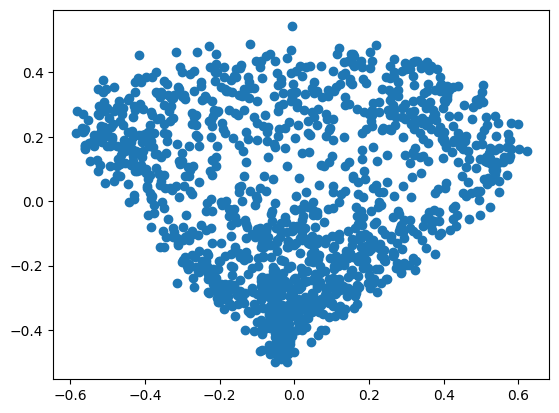

In [31]:
plt.scatter(all_transformed.iloc[:, 0], all_transformed.iloc[:, 1])

In [32]:
OU_df_saved.iloc[0]

drybulb_0         6.619041
drybulb_1       -18.664304
drybulb_2         0.003608
relhum_0         26.044690
relhum_1         41.359542
relhum_2          0.002698
winddir_0       124.709010
winddir_1       -10.468363
winddir_2         0.000406
dirnorrad_0     330.364658
dirnorrad_1    -230.951762
dirnorrad_2       0.000732
difhorrad_0      62.327074
difhorrad_1       2.576709
difhorrad_2       0.000318
windspd_0         3.734412
windspd_1         2.758711
windspd_2         0.000695
precip_wtr_0     79.346858
precip_wtr_1    -33.691203
precip_wtr_2      0.018616
snowdepth_0       0.000000
snowdepth_1       0.000000
snowdepth_2       0.001000
Name: 1, dtype: float64

In [33]:
OU_mean

drybulb_0       0.726880
drybulb_1      -1.100279
drybulb_2       0.004113
relhum_0        1.119873
relhum_1        1.396569
relhum_2        0.003250
winddir_0       1.467288
winddir_1      -0.231831
winddir_2       0.000344
dirnorrad_0     0.806122
dirnorrad_1    -0.271714
dirnorrad_2     0.000599
difhorrad_0     0.753601
difhorrad_1     0.128952
difhorrad_2     0.000356
windspd_0       1.467094
windspd_1       0.185073
windspd_2       0.000485
precip_wtr_0    1.048878
precip_wtr_1   -0.211666
precip_wtr_2    0.020536
snowdepth_0     0.289412
snowdepth_1     0.079111
snowdepth_2     0.003044
dtype: float64

In [34]:
# sample = np.random.uniform(-0.5, 0, [1, 3])
sample = np.array([[-0.3, -0.3]])
sampled_OU_vars = pca.inverse_transform(sample)
sampled_OU_vars = sampled_OU_vars * np.array(OU_std)[None, -1] + np.array(OU_mean)[None, -1]
store_OU_mean = deepcopy(OU_mean)
store_OU_std = deepcopy(OU_std)
store_OU_min = deepcopy(OU_min)
store_OU_max = deepcopy(OU_max)
store_base_OU = deepcopy(base_OU_params)
for i, column in enumerate(OU_df.columns):
    delim_idx = column.rfind("_")
    var = column[:delim_idx]
    idx = int(column[delim_idx+1:])
    if idx in [0, 1]:
        sampled_OU_vars[:, i] *= df_std[i//3]
        store_OU_mean[i] *= df_std[i//3]
        store_OU_std[i] *= df_std[i//3]
        store_OU_max[i] *= df_std[i//3]
        store_OU_min[i] *= df_std[i//3]


In [35]:
store_OU_mean

drybulb_0         6.544343
drybulb_1        -9.906180
drybulb_2         0.004113
relhum_0         26.633425
relhum_1         33.213955
relhum_2          0.003250
winddir_0       120.638017
winddir_1       -19.060754
winddir_2         0.000344
dirnorrad_0     289.147122
dirnorrad_1     -97.460831
dirnorrad_2       0.000599
difhorrad_0      65.128118
difhorrad_1      11.144331
difhorrad_2       0.000356
windspd_0         2.657861
windspd_1         0.335287
windspd_2         0.000485
precip_wtr_0     88.177361
precip_wtr_1    -17.794375
precip_wtr_2      0.020536
snowdepth_0       0.289412
snowdepth_1       0.079111
snowdepth_2       0.003044
dtype: float64

In [36]:
from importlib import reload
import epw_data
from epw_data import EPW_Data
reload(epw_data)

import pickle
epw_data_ = epw_data.EPW_Data(OU_df_saved, all_transformed, pca, store_OU_mean, store_OU_std, store_OU_min, store_OU_max, store_weather_min, store_weather_max, store_base_OU)
epw_data_.save("US_epw_OU_data.pkl")
# with open("US_epw_OU_data.pkl", 'wb') as f:
#     pickle.dump(epw_data_, f)

In [37]:
loaded_data = epw_data.EPW_Data.load("US_epw_OU_data.pkl")
# with open("US_epw_OU_data.pkl", 'rb') as f:
#     loaded_data = pickle.load(f)

In [38]:
loaded_data.OU_mean

drybulb_0         6.544343
drybulb_1        -9.906180
drybulb_2         0.004113
relhum_0         26.633425
relhum_1         33.213955
relhum_2          0.003250
winddir_0       120.638017
winddir_1       -19.060754
winddir_2         0.000344
dirnorrad_0     289.147122
dirnorrad_1     -97.460831
dirnorrad_2       0.000599
difhorrad_0      65.128118
difhorrad_1      11.144331
difhorrad_2       0.000356
windspd_0         2.657861
windspd_1         0.335287
windspd_2         0.000485
precip_wtr_0     88.177361
precip_wtr_1    -17.794375
precip_wtr_2      0.020536
snowdepth_0       0.289412
snowdepth_1       0.079111
snowdepth_2       0.003044
dtype: float64

In [39]:
loaded_data.read_OU_param(loaded_data.OU_mean, "precip_wtr")

array([ 8.81773612e+01, -1.77943745e+01,  2.05359761e-02])